# Sequence to sequence learning for performing number addition

### Setup

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from tqdm import tqdm

In [3]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS


### Generate the data

In [4]:
class CharacterTable:
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """

    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)


# All the numbers, plus sign and space for padding.
chars = "0123456789+ "
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print("Generating data...")
while len(questions) < TRAINING_SIZE:
    f = lambda: int(
        "".join(
            np.random.choice(list("0123456789"))
            for i in range(np.random.randint(1, DIGITS + 1))
        )
    )
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = "{}+{}".format(a, b)
    query = q + " " * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += " " * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print("Total questions:", len(questions))


Generating data...
Total questions: 50000


### Print last 10 questions 

In [5]:
from pprint import pprint
pprint(questions[:10])

['   4+73',
 '  65+44',
 '   32+3',
 '   79+4',
 '  33+03',
 ' 178+91',
 '   7+04',
 '  01+81',
 '   0+09',
 ' 49+715']


### Vectorize the data

In [6]:
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype = bool)

y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype = bool)

In [7]:
print("dimension of x : ", x.shape)
print("dimension of y : ", y.shape)

dimension of x :  (50000, 7, 12)
dimension of y :  (50000, 4, 12)


### Encode the data

In [8]:
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

### Shuffle x and y

In [9]:
indices = np.arange(len(y))
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

print("dimension of x : ", x.shape)
print("dimension of y : ", y.shape)

dimension of x :  (50000, 7, 12)
dimension of y :  (50000, 4, 12)


In [29]:
# Explicitly set apart 10% for validation data that we never train over.
# split_at = len(x) - len(x) // 10
# (x_train, x_test) = x[:split_at], x[split_at:]
# (y_train, y_test) = y[:split_at], y[split_at:]

### Split data in train and test

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y, 
    test_size = 0.2, 
    random_state = 42
)

In [11]:
print("dimension of x_train : ", x_train.shape)
print("dimension of y_train : ", y_train.shape)
print("dimension of x_test : ", x_test.shape)
print("dimension of y_test : ", y_test.shape)

dimension of x_train :  (40000, 7, 12)
dimension of y_train :  (40000, 4, 12)
dimension of x_test :  (10000, 7, 12)
dimension of y_test :  (10000, 4, 12)


### Create model

In [13]:
import tensorflow
num_layers = 1

model = keras.Sequential()
# "Encode" the input sequence using a LSTM, producing an output of size 128.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(layers.LSTM(128, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN can be multiple layers stacked or a single layer.
for _ in range(num_layers):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(layers.LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.Dense(len(chars), activation="softmax"))

#previous numpy version numpy-1.22.3 generated errors like :
#NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

#so according to https://github.com/tensorflow/models/issues/9706#issuecomment-782841778
# dowgrade numpy to 1.19.5

### Compile the model

In [14]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

### Model Summary

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               72192     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 4, 128)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 4, 128)            131584    
                                                                 
 dense_1 (Dense)             (None, 4, 12)             1548      
                                                                 
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


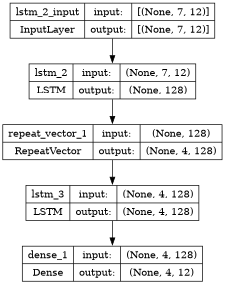

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
        show_shapes=True, 
        show_layer_names=True, 
        expand_nested=True, 
        dpi=50, 
        to_file="perform_number_addition_using_seq_to_seq_learning_LSTM.png"
)



### Train the model
Train the model on each epochs and predict the validation data

In [ ]:


epochs = 30
batch_size = 32


# Train the model each generation and show predictions against the validation
# dataset.
for epoch in tqdm(range(1, epochs)):
    print()
    print("\nIteration", epoch)
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=(x_test, y_test),
    )
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_test))
        rowx, rowy = x_test[np.array([ind])], y_test[np.array([ind])]
        preds = np.argmax(model.predict(rowx), axis=-1)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print("Q", q[::-1] if REVERSE else q, end=" ")
        print("T", correct, end=" ")
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)

  0%|          | 0/29 [00:00<?, ?it/s]



Iteration 1
1/1 [==============================] - 2s 2s/step
Q 963+600 T 1563 ☒ 1407
1/1 [==============================] - 0s 53ms/step
Q 91+961  T 1052 ☒ 1010
1/1 [==============================] - 0s 49ms/step
Q 12+456  T 468  ☒ 267 
1/1 [==============================] - 0s 52ms/step
Q 354+444 T 798  ☒ 617 
1/1 [==============================] - 0s 48ms/step
Q 7+140   T 147  ☒ 157 
1/1 [==============================] - 0s 54ms/step
Q 980+751 T 1731 ☒ 1607
1/1 [==============================] - 0s 53ms/step
Q 603+146 T 749  ☒ 607 
1/1 [==============================] - 0s 55ms/step
Q 753+3   T 756  ☒ 667 
1/1 [==============================] - 0s 54ms/step
Q 633+8   T 641  ☒ 637 
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 1/29 [01:06<31:12, 66.89s/it]

Q 40+44   T 84   ☒ 44  


Iteration 2
1/1 [==============================] - 0s 48ms/step
Q 706+0   T 706  ☒ 721 
1/1 [==============================] - 0s 46ms/step
Q 12+227  T 239  ☒ 235 
1/1 [==============================] - 0s 47ms/step
Q 938+28  T 966  ☒ 951 
1/1 [==============================] - 0s 51ms/step
Q 264+718 T 982  ☒ 101 
1/1 [==============================] - 0s 50ms/step
Q 670+49  T 719  ☒ 711 
1/1 [==============================] - 0s 50ms/step
Q 79+649  T 728  ☒ 661 
1/1 [==============================] - 0s 60ms/step
Q 34+730  T 764  ☒ 711 
1/1 [==============================] - 0s 47ms/step
Q 250+683 T 933  ☒ 901 
1/1 [==============================] - 0s 53ms/step
Q 211+248 T 459  ☒ 466 
1/1 [==============================] - 0s 57ms/step


  7%|▋         | 2/29 [01:55<25:18, 56.26s/it]

Q 638+518 T 1156 ☒ 1111


Iteration 3
1/1 [==============================] - 0s 52ms/step
Q 80+169  T 249  ☒ 238 
1/1 [==============================] - 0s 49ms/step
Q 380+941 T 1321 ☒ 1220
1/1 [==============================] - 0s 55ms/step
Q 409+689 T 1098 ☒ 1008
1/1 [==============================] - 0s 55ms/step
Q 620+4   T 624  ☒ 623 
1/1 [==============================] - 0s 50ms/step
Q 298+93  T 391  ☒ 368 
1/1 [==============================] - 0s 51ms/step
Q 21+57   T 78   ☒ 76  
1/1 [==============================] - 0s 51ms/step
Q 9+490   T 499  ☑ 499 
1/1 [==============================] - 0s 77ms/step
Q 885+61  T 946  ☒ 943 
1/1 [==============================] - 0s 46ms/step
Q 794+6   T 800  ☒ 798 
1/1 [==============================] - 0s 49ms/step


 10%|█         | 3/29 [02:45<23:05, 53.29s/it]

Q 744+43  T 787  ☒ 788 


Iteration 4
1/1 [==============================] - 0s 49ms/step
Q 967+469 T 1436 ☒ 1431
1/1 [==============================] - 0s 52ms/step
Q 416+54  T 470  ☒ 469 
1/1 [==============================] - 0s 49ms/step
Q 7+646   T 653  ☒ 651 
1/1 [==============================] - 0s 56ms/step
Q 76+309  T 385  ☒ 389 
1/1 [==============================] - 0s 46ms/step
Q 22+67   T 89   ☒ 80  
1/1 [==============================] - 0s 51ms/step
Q 54+65   T 119  ☒ 111 
1/1 [==============================] - 0s 53ms/step
Q 37+82   T 119  ☒ 121 
1/1 [==============================] - 0s 55ms/step
Q 75+475  T 550  ☒ 549 
1/1 [==============================] - 0s 53ms/step
Q 847+97  T 944  ☒ 949 
1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 4/29 [03:33<21:22, 51.31s/it]

Q 90+209  T 299  ☒ 294 


Iteration 5
1/1 [==============================] - 0s 50ms/step
Q 69+106  T 175  ☒ 170 
1/1 [==============================] - 0s 50ms/step
Q 670+892 T 1562 ☒ 1550
1/1 [==============================] - 0s 51ms/step
Q 8+680   T 688  ☒ 689 
1/1 [==============================] - 0s 52ms/step
Q 10+70   T 80   ☒ 84  
1/1 [==============================] - 0s 52ms/step
Q 5+838   T 843  ☒ 849 
1/1 [==============================] - 0s 54ms/step
Q 989+263 T 1252 ☒ 1250
1/1 [==============================] - 0s 54ms/step
Q 45+389  T 434  ☒ 432 
1/1 [==============================] - 0s 51ms/step
Q 408+523 T 931  ☒ 900 
1/1 [==============================] - 0s 52ms/step
Q 3+340   T 343  ☒ 346 
1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 5/29 [04:25<20:38, 51.60s/it]

Q 448+872 T 1320 ☒ 1412


Iteration 6
1/1 [==============================] - 0s 83ms/step
Q 20+867  T 887  ☑ 887 
1/1 [==============================] - 0s 112ms/step
Q 32+911  T 943  ☒ 940 
1/1 [==============================] - 0s 56ms/step
Q 77+17   T 94   ☒ 90  
1/1 [==============================] - 0s 61ms/step
Q 481+523 T 1004 ☒ 1000
1/1 [==============================] - 0s 53ms/step
Q 42+579  T 621  ☒ 620 
1/1 [==============================] - 0s 51ms/step
Q 50+31   T 81   ☒ 77  
1/1 [==============================] - 0s 87ms/step
Q 756+630 T 1386 ☒ 1387
1/1 [==============================] - 0s 58ms/step
Q 236+695 T 931  ☒ 132 
1/1 [==============================] - 0s 50ms/step
Q 158+70  T 228  ☒ 220 
1/1 [==============================] - 0s 52ms/step


 21%|██        | 6/29 [05:08<18:38, 48.62s/it]

Q 800+710 T 1510 ☒ 1509


Iteration 7
1/1 [==============================] - 0s 46ms/step
Q 301+435 T 736  ☒ 733 
1/1 [==============================] - 0s 52ms/step
Q 22+583  T 605  ☒ 603 
1/1 [==============================] - 0s 73ms/step
Q 371+23  T 394  ☒ 393 
1/1 [==============================] - 0s 44ms/step
Q 277+659 T 936  ☒ 935 
1/1 [==============================] - 0s 54ms/step
Q 6+474   T 480  ☒ 481 
1/1 [==============================] - 0s 54ms/step
Q 104+347 T 451  ☒ 455 
1/1 [==============================] - 0s 69ms/step
Q 579+15  T 594  ☒ 595 
1/1 [==============================] - 0s 50ms/step
Q 993+13  T 1006 ☒ 1001
1/1 [==============================] - 0s 48ms/step
Q 235+83  T 318  ☒ 319 
1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 7/29 [06:00<18:09, 49.52s/it]

Q 210+134 T 344  ☒ 346 


Iteration 8
1/1 [==============================] - 0s 46ms/step
Q 464+130 T 594  ☒ 593 
1/1 [==============================] - 0s 48ms/step
Q 86+863  T 949  ☒ 955 
1/1 [==============================] - 0s 57ms/step
Q 69+14   T 83   ☒ 92  
1/1 [==============================] - 0s 56ms/step
Q 985+93  T 1078 ☒ 1070
1/1 [==============================] - 0s 51ms/step
Q 62+43   T 105  ☒ 10  
1/1 [==============================] - 0s 67ms/step
Q 263+6   T 269  ☑ 269 
1/1 [==============================] - 0s 53ms/step
Q 569+49  T 618  ☒ 605 
1/1 [==============================] - 0s 56ms/step
Q 526+930 T 1456 ☒ 1566
1/1 [==============================] - 0s 67ms/step
Q 901+6   T 907  ☑ 907 
1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 8/29 [06:51<17:33, 50.15s/it]

Q 993+1   T 994  ☒ 984 


Iteration 9
1/1 [==============================] - 0s 91ms/step
Q 144+811 T 955  ☑ 955 
1/1 [==============================] - 0s 58ms/step
Q 197+939 T 1136 ☑ 1136
1/1 [==============================] - 0s 50ms/step
Q 574+615 T 1189 ☑ 1189
1/1 [==============================] - 0s 58ms/step
Q 31+462  T 493  ☑ 493 
1/1 [==============================] - 0s 55ms/step
Q 19+142  T 161  ☑ 161 
1/1 [==============================] - 0s 51ms/step
Q 57+847  T 904  ☑ 904 
1/1 [==============================] - 0s 58ms/step
Q 105+784 T 889  ☒ 899 
1/1 [==============================] - 0s 57ms/step
Q 459+3   T 462  ☑ 462 
1/1 [==============================] - 0s 62ms/step
Q 58+675  T 733  ☑ 733 
1/1 [==============================] - 0s 52ms/step


 31%|███       | 9/29 [07:45<17:09, 51.48s/it]

Q 30+45   T 75   ☒ 76  


Iteration 10
1/1 [==============================] - 0s 45ms/step
Q 267+7   T 274  ☑ 274 
1/1 [==============================] - 0s 45ms/step
Q 297+573 T 870  ☑ 870 
1/1 [==============================] - 0s 60ms/step
Q 31+810  T 841  ☑ 841 
1/1 [==============================] - 0s 56ms/step
Q 450+162 T 612  ☒ 613 
1/1 [==============================] - 0s 51ms/step
Q 291+48  T 339  ☑ 339 
1/1 [==============================] - 0s 50ms/step
Q 45+350  T 395  ☑ 395 
1/1 [==============================] - 0s 53ms/step
Q 813+60  T 873  ☑ 873 
1/1 [==============================] - 0s 54ms/step
Q 35+538  T 573  ☑ 573 
1/1 [==============================] - 0s 60ms/step
Q 0+744   T 744  ☑ 744 
1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 10/29 [08:37<16:17, 51.42s/it]

Q 4+343   T 347  ☑ 347 


Iteration 11
1/1 [==============================] - 0s 47ms/step
Q 4+684   T 688  ☑ 688 
1/1 [==============================] - 0s 52ms/step
Q 89+26   T 115  ☑ 115 
1/1 [==============================] - 0s 51ms/step
Q 848+625 T 1473 ☑ 1473
1/1 [==============================] - 0s 55ms/step
Q 937+19  T 956  ☒ 955 
1/1 [==============================] - 0s 47ms/step
Q 442+721 T 1163 ☑ 1163
1/1 [==============================] - 0s 57ms/step
Q 497+7   T 504  ☑ 504 
1/1 [==============================] - 0s 51ms/step
Q 307+93  T 400  ☒ 300 
1/1 [==============================] - 0s 57ms/step
Q 883+540 T 1423 ☑ 1423
1/1 [==============================] - 0s 58ms/step
Q 209+403 T 612  ☒ 522 
1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 11/29 [09:22<14:51, 49.52s/it]

Q 50+81   T 131  ☑ 131 


Iteration 12
1/1 [==============================] - 0s 89ms/step
Q 792+27  T 819  ☑ 819 
1/1 [==============================] - 0s 47ms/step
Q 4+252   T 256  ☑ 256 
1/1 [==============================] - 0s 59ms/step
Q 54+23   T 77   ☑ 77  
1/1 [==============================] - 0s 57ms/step
Q 33+730  T 763  ☑ 763 
1/1 [==============================] - 0s 48ms/step
Q 72+546  T 618  ☑ 618 
1/1 [==============================] - 0s 64ms/step
Q 2+426   T 428  ☑ 428 
1/1 [==============================] - 0s 53ms/step
Q 8+308   T 316  ☑ 316 
1/1 [==============================] - 0s 63ms/step
Q 272+31  T 303  ☑ 303 
1/1 [==============================] - 0s 54ms/step
Q 4+284   T 288  ☑ 288 
1/1 [==============================] - 0s 59ms/step


 41%|████▏     | 12/29 [10:11<14:00, 49.46s/it]

Q 68+371  T 439  ☒ 449 


Iteration 13
1/1 [==============================] - 0s 52ms/step
Q 98+533  T 631  ☑ 631 
1/1 [==============================] - 0s 58ms/step
Q 78+909  T 987  ☑ 987 
1/1 [==============================] - 0s 52ms/step
Q 200+577 T 777  ☑ 777 
1/1 [==============================] - 0s 64ms/step
Q 22+70   T 92   ☑ 92  
1/1 [==============================] - 0s 49ms/step
Q 7+238   T 245  ☑ 245 
1/1 [==============================] - 0s 55ms/step
Q 826+943 T 1769 ☑ 1769
1/1 [==============================] - 0s 56ms/step
Q 701+560 T 1261 ☑ 1261
1/1 [==============================] - 0s 55ms/step
Q 340+818 T 1158 ☑ 1158
1/1 [==============================] - 0s 74ms/step
Q 37+831  T 868  ☑ 868 
1/1 [==============================] - 0s 64ms/step


 45%|████▍     | 13/29 [10:53<12:34, 47.16s/it]

Q 72+429  T 501  ☑ 501 


Iteration 14
1/1 [==============================] - 0s 47ms/step
Q 55+199  T 254  ☑ 254 
1/1 [==============================] - 0s 57ms/step
Q 84+49   T 133  ☑ 133 
1/1 [==============================] - 0s 58ms/step
Q 212+568 T 780  ☑ 780 
1/1 [==============================] - 0s 54ms/step
Q 7+746   T 753  ☑ 753 
1/1 [==============================] - 0s 53ms/step
Q 947+4   T 951  ☑ 951 
1/1 [==============================] - 0s 56ms/step
Q 697+80  T 777  ☑ 777 
1/1 [==============================] - 0s 54ms/step
Q 348+341 T 689  ☑ 689 
1/1 [==============================] - 0s 55ms/step
Q 11+830  T 841  ☑ 841 
1/1 [==============================] - 0s 57ms/step
Q 387+465 T 852  ☑ 852 
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 14/29 [11:37<11:30, 46.05s/it]

Q 284+45  T 329  ☑ 329 


Iteration 15
1/1 [==============================] - 0s 50ms/step
Q 643+925 T 1568 ☑ 1568
1/1 [==============================] - 0s 56ms/step
Q 83+186  T 269  ☑ 269 
1/1 [==============================] - 0s 59ms/step
Q 48+244  T 292  ☒ 392 
1/1 [==============================] - 0s 51ms/step
Q 324+8   T 332  ☑ 332 
1/1 [==============================] - 0s 70ms/step
Q 539+7   T 546  ☑ 546 
1/1 [==============================] - 0s 57ms/step
Q 606+88  T 694  ☑ 694 
1/1 [==============================] - 0s 55ms/step
Q 365+97  T 462  ☑ 462 
1/1 [==============================] - 0s 54ms/step
Q 756+95  T 851  ☑ 851 
1/1 [==============================] - 0s 62ms/step
Q 647+26  T 673  ☑ 673 
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 15/29 [12:12<09:58, 42.77s/it]

Q 446+110 T 556  ☑ 556 


Iteration 16
1/1 [==============================] - 0s 64ms/step
Q 65+939  T 1004 ☑ 1004
1/1 [==============================] - 0s 72ms/step
Q 258+528 T 786  ☑ 786 
1/1 [==============================] - 0s 72ms/step
Q 790+94  T 884  ☑ 884 
1/1 [==============================] - 0s 71ms/step
Q 956+449 T 1405 ☑ 1405
1/1 [==============================] - 0s 67ms/step
Q 761+663 T 1424 ☑ 1424
1/1 [==============================] - 0s 53ms/step
Q 818+41  T 859  ☑ 859 
1/1 [==============================] - 0s 56ms/step
Q 542+59  T 601  ☑ 601 
1/1 [==============================] - 0s 59ms/step
Q 349+264 T 613  ☑ 613 
1/1 [==============================] - 0s 58ms/step
Q 715+575 T 1290 ☑ 1290
1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 16/29 [13:04<09:51, 45.54s/it]

Q 807+694 T 1501 ☑ 1501


Iteration 17
1/1 [==============================] - 0s 50ms/step
Q 16+994  T 1010 ☒ 1000
1/1 [==============================] - 0s 52ms/step
Q 55+500  T 555  ☑ 555 
1/1 [==============================] - 0s 68ms/step
Q 973+573 T 1546 ☑ 1546
1/1 [==============================] - 0s 52ms/step
Q 195+64  T 259  ☑ 259 
1/1 [==============================] - 0s 56ms/step
Q 284+568 T 852  ☑ 852 
1/1 [==============================] - 0s 62ms/step
Q 90+485  T 575  ☑ 575 
1/1 [==============================] - 0s 48ms/step
Q 50+93   T 143  ☑ 143 
1/1 [==============================] - 0s 56ms/step
Q 914+907 T 1821 ☑ 1821
1/1 [==============================] - 0s 61ms/step
Q 679+796 T 1475 ☑ 1475
1/1 [==============================] - 0s 50ms/step


 59%|█████▊    | 17/29 [13:55<09:25, 47.12s/it]

Q 33+842  T 875  ☑ 875 


Iteration 18
1/1 [==============================] - 0s 48ms/step
Q 409+0   T 409  ☑ 409 
1/1 [==============================] - 0s 46ms/step
Q 47+871  T 918  ☑ 918 
1/1 [==============================] - 0s 65ms/step
Q 233+74  T 307  ☑ 307 
1/1 [==============================] - 0s 50ms/step
Q 557+154 T 711  ☑ 711 
1/1 [==============================] - 0s 56ms/step
Q 37+10   T 47   ☑ 47  
1/1 [==============================] - 0s 55ms/step
Q 22+757  T 779  ☑ 779 
1/1 [==============================] - 0s 54ms/step
Q 697+19  T 716  ☑ 716 
1/1 [==============================] - 0s 58ms/step
Q 441+769 T 1210 ☑ 1210
1/1 [==============================] - 0s 52ms/step
Q 2+121   T 123  ☑ 123 
1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 18/29 [14:46<08:53, 48.52s/it]

Q 66+822  T 888  ☑ 888 


Iteration 19
1/1 [==============================] - 0s 45ms/step
Q 9+47    T 56   ☑ 56  
1/1 [==============================] - 0s 63ms/step
Q 910+79  T 989  ☑ 989 
1/1 [==============================] - 0s 59ms/step
Q 62+272  T 334  ☑ 334 
1/1 [==============================] - 0s 54ms/step
Q 175+601 T 776  ☑ 776 
1/1 [==============================] - 0s 65ms/step
Q 214+180 T 394  ☑ 394 
1/1 [==============================] - 0s 55ms/step
Q 303+215 T 518  ☑ 518 
1/1 [==============================] - 0s 69ms/step
Q 293+177 T 470  ☑ 470 
1/1 [==============================] - 0s 75ms/step
Q 71+63   T 134  ☑ 134 
1/1 [==============================] - 0s 64ms/step
Q 91+715  T 806  ☑ 806 
1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 19/29 [15:41<08:23, 50.30s/it]

Q 403+769 T 1172 ☑ 1172


Iteration 20
1/1 [==============================] - 0s 76ms/step
Q 757+204 T 961  ☑ 961 
1/1 [==============================] - 0s 90ms/step
Q 880+352 T 1232 ☑ 1232
1/1 [==============================] - 0s 75ms/step
Q 381+959 T 1340 ☑ 1340
1/1 [==============================] - 0s 57ms/step
Q 7+935   T 942  ☑ 942 
1/1 [==============================] - 0s 72ms/step
Q 185+2   T 187  ☑ 187 
1/1 [==============================] - 0s 63ms/step
Q 486+760 T 1246 ☑ 1246
1/1 [==============================] - 0s 61ms/step
Q 162+2   T 164  ☑ 164 
1/1 [==============================] - 0s 53ms/step
Q 919+199 T 1118 ☒ 1108
1/1 [==============================] - 0s 57ms/step
Q 867+52  T 919  ☑ 919 
1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 20/29 [16:35<07:43, 51.48s/it]

Q 29+489  T 518  ☑ 518 


Iteration 21
1/1 [==============================] - 0s 50ms/step
Q 118+40  T 158  ☑ 158 
1/1 [==============================] - 0s 68ms/step
Q 927+8   T 935  ☑ 935 
1/1 [==============================] - 0s 56ms/step
Q 2+33    T 35   ☑ 35  
1/1 [==============================] - 0s 55ms/step
Q 555+2   T 557  ☑ 557 
1/1 [==============================] - 0s 52ms/step
Q 8+760   T 768  ☑ 768 
1/1 [==============================] - 0s 61ms/step
Q 375+342 T 717  ☑ 717 
1/1 [==============================] - 0s 95ms/step
Q 182+52  T 234  ☑ 234 
1/1 [==============================] - 0s 63ms/step
Q 52+647  T 699  ☑ 699 
1/1 [==============================] - 0s 57ms/step
Q 730+27  T 757  ☑ 757 
1/1 [==============================] - 0s 76ms/step
Q

 72%|███████▏  | 21/29 [17:24<06:45, 50.67s/it]

 221+55  T 276  ☑ 276 


Iteration 22
1/1 [==============================] - 0s 49ms/step
Q 530+484 T 1014 ☑ 1014
1/1 [==============================] - 0s 56ms/step
Q 456+3   T 459  ☑ 459 
1/1 [==============================] - 0s 63ms/step
Q 6+617   T 623  ☑ 623 
1/1 [==============================] - 0s 54ms/step
Q 536+61  T 597  ☑ 597 
1/1 [==============================] - 0s 53ms/step
Q 22+178  T 200  ☒ 101 
1/1 [==============================] - 0s 51ms/step
Q 66+82   T 148  ☑ 148 
1/1 [==============================] - 0s 53ms/step
Q 8+64    T 72   ☑ 72  
1/1 [==============================] - 0s 57ms/step
Q 613+17  T 630  ☒ 631 
1/1 [==============================] - 0s 53ms/step
Q 419+6   T 425  ☑ 425 
1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 22/29 [18:16<05:58, 51.23s/it]

Q 77+162  T 239  ☑ 239 


Iteration 23
1/1 [==============================] - 0s 63ms/step
Q 340+560 T 900  ☑ 900 
1/1 [==============================] - 0s 82ms/step
Q 10+46   T 56   ☑ 56  
1/1 [==============================] - 0s 59ms/step
Q 311+401 T 712  ☑ 712 
1/1 [==============================] - 0s 65ms/step
Q 623+68  T 691  ☑ 691 
1/1 [==============================] - 0s 68ms/step
Q 572+3   T 575  ☑ 575 
1/1 [==============================] - 0s 65ms/step
Q 210+134 T 344  ☑ 344 
1/1 [==============================] - 0s 69ms/step
Q 60+77   T 137  ☑ 137 
1/1 [==============================] - 0s 82ms/step
Q 824+72  T 896  ☑ 896 
1/1 [==============================] - 0s 57ms/step
Q 4+945   T 949  ☑ 949 
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 23/29 [19:11<05:13, 52.17s/it]

Q 14+291  T 305  ☑ 305 


Iteration 24
1/1 [==============================] - 0s 59ms/step
Q 340+38  T 378  ☑ 378 
1/1 [==============================] - 0s 71ms/step
Q 30+200  T 230  ☑ 230 
1/1 [==============================] - 0s 57ms/step
Q 56+981  T 1037 ☑ 1037
1/1 [==============================] - 0s 59ms/step
Q 150+520 T 670  ☑ 670 
1/1 [==============================] - 0s 57ms/step
Q 939+306 T 1245 ☑ 1245
1/1 [==============================] - 0s 60ms/step
Q 801+50  T 851  ☑ 851 
1/1 [==============================] - 0s 63ms/step
Q 30+684  T 714  ☑ 714 
1/1 [==============================] - 0s 57ms/step
Q 308+434 T 742  ☑ 742 
1/1 [==============================] - 0s 59ms/step
Q 616+54  T 670  ☑ 670 
1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 24/29 [20:02<04:20, 52.04s/it]

Q 229+925 T 1154 ☑ 1154


Iteration 25
1/1 [==============================] - 0s 70ms/step
Q 979+0   T 979  ☑ 979 
1/1 [==============================] - 0s 77ms/step
Q 165+201 T 366  ☑ 366 
1/1 [==============================] - 0s 61ms/step
Q 732+245 T 977  ☑ 977 
1/1 [==============================] - 0s 63ms/step
Q 60+300  T 360  ☑ 360 
1/1 [==============================] - 0s 58ms/step
Q 200+67  T 267  ☑ 267 
1/1 [==============================] - 0s 59ms/step
Q 46+785  T 831  ☑ 831 
1/1 [==============================] - 0s 57ms/step
Q 875+13  T 888  ☑ 888 
1/1 [==============================] - 0s 58ms/step
Q 41+61   T 102  ☑ 102 
1/1 [==============================] - 0s 67ms/step
Q 0+455   T 455  ☑ 455 
1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 25/29 [20:55<03:28, 52.15s/it]

Q 223+4   T 227  ☑ 227 


Iteration 26
1/1 [==============================] - 0s 61ms/step
Q 0+375   T 375  ☑ 375 
1/1 [==============================] - 0s 79ms/step
Q 8+614   T 622  ☑ 622 
1/1 [==============================] - 0s 69ms/step
Q 2+757   T 759  ☑ 759 
1/1 [==============================] - 0s 58ms/step
Q 5+639   T 644  ☑ 644 
1/1 [==============================] - 0s 90ms/step
Q 878+2   T 880  ☑ 880 
1/1 [==============================] - 0s 64ms/step
Q 209+15  T 224  ☑ 224 
1/1 [==============================] - 0s 65ms/step
Q 69+227  T 296  ☑ 296 
1/1 [==============================] - 0s 61ms/step
Q 23+323  T 346  ☑ 346 
1/1 [==============================] - 0s 63ms/step
Q 306+574 T 880  ☑ 880 
1/1 [==============================] - 0s 78ms/step


 90%|████████▉ | 26/29 [21:44<02:33, 51.12s/it]

Q 842+77  T 919  ☑ 919 


Iteration 27
1/1 [==============================] - 0s 53ms/step
Q 13+466  T 479  ☒ 480 
1/1 [==============================] - 0s 64ms/step
Q 89+590  T 679  ☑ 679 
1/1 [==============================] - 0s 60ms/step
Q 962+94  T 1056 ☑ 1056
1/1 [==============================] - 0s 62ms/step
Q 0+727   T 727  ☑ 727 
1/1 [==============================] - 0s 63ms/step
Q 370+644 T 1014 ☑ 1014
1/1 [==============================] - 0s 72ms/step
Q 542+7   T 549  ☑ 549 
1/1 [==============================] - 0s 57ms/step
Q 24+855  T 879  ☑ 879 
1/1 [==============================] - 0s 61ms/step
Q 195+64  T 259  ☑ 259 
1/1 [==============================] - 0s 62ms/step
Q 625+21  T 646  ☒ 647 
1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 27/29 [22:36<01:43, 51.61s/it]

Q 54+292  T 346  ☑ 346 


Iteration 28
1/1 [==============================] - 0s 71ms/step
Q 954+11  T 965  ☑ 965 
1/1 [==============================] - 0s 93ms/step
Q 30+684  T 714  ☑ 714 
1/1 [==============================] - 0s 61ms/step
Q 253+31  T 284  ☑ 284 
1/1 [==============================] - 0s 66ms/step
Q 469+5   T 474  ☑ 474 
1/1 [==============================] - 0s 68ms/step
Q 21+191  T 212  ☑ 212 
1/1 [==============================] - 0s 60ms/step
Q 254+242 T 496  ☑ 496 
1/1 [==============================] - 0s 60ms/step
Q 4+702   T 706  ☑ 706 
1/1 [==============================] - 0s 82ms/step
Q 5+877   T 882  ☑ 882 
1/1 [==============================] - 0s 70ms/step
Q 812+86  T 898  ☑ 898 
1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 28/29 [23:30<00:52, 52.14s/it]

Q 47+380  T 427  ☑ 427 


Iteration 29
1/1 [==============================] - 0s 55ms/step
Q 820+84  T 904  ☑ 904 
1/1 [==============================] - 0s 59ms/step
Q 24+558  T 582  ☑ 582 
1/1 [==============================] - 0s 63ms/step
Q 504+729 T 1233 ☑ 1233
1/1 [==============================] - 0s 55ms/step
Q 811+84  T 895  ☑ 895 
1/1 [==============================] - 0s 55ms/step
Q 902+754 T 1656 ☑ 1656
1/1 [==============================] - 0s 59ms/step
Q 31+48   T 79   ☒ 89  
1/1 [==============================] - 0s 58ms/step
Q 66+2    T 68   ☑ 68  
1/1 [==============================] - 0s 59ms/step
Q 65+6    T 71   ☑ 71  
1/1 [==============================] - 0s 64ms/step
Q 165+563 T 728  ☑ 728 
1/1 [==============================] - 0s 58ms/step


100%|██████████| 29/29 [24:21<00:00, 50.39s/it]

Q 17+134  T 151  ☑ 151 


In [18]:
# from tqdm import tqdm
# for i in tqdm(range(100000)):
#     print(i)

# Reference 

- https://keras.io/examples/nlp/addition_rnn/
- https://medium.com/@nutanbhogendrasharma/sequence-to-sequence-learning-with-neural-networks-to-perform-number-addition-7ef0df7afaa4